In [30]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import sys
import json
import pandas as pd
from IPython.display import clear_output

if sys.platform == 'win32':
    path = 'C:/Users/Garren/Documents/Article - Pure PMF/Pure_MC'
else:
    path = '/home/garren/Documents/Article - Pure PMF/Pure_MC'
sys.path.insert(0, path)

from Post_procs import Post_process

In [2]:
png_path = f'{path}/Comparison_Between_298_and_all'
os.makedirs(png_path, exist_ok=True)

In [3]:
matplotlib.use('qt5agg')
%matplotlib inline

In [4]:
T = '298'
c = True
z = True
t = True
post_obj = Post_process(include_clusters=c,
                        include_zeros=z,
                        refT=t,
                        T=T)

testing_indices = post_obj.testing_indices.copy()
Idx_known = post_obj.Idx_known.copy()
c_all = post_obj.c_all.copy()
fg = post_obj.fg.copy()

A_298 = post_obj.get_tensors()
data_dict_298_testing = post_obj.get_testing_values(A=A_298)
data_dict_298_training = post_obj.get_reconstructed_values(A=A_298)

In [5]:
T = 'all'
c = True
z = True
t = True
post_obj = Post_process(include_clusters=c,
                        include_zeros=z,
                        refT=t,
                        T=T)
A_all = post_obj.get_tensors()
data_dict_all_testing = post_obj.get_testing_values(A=A_all)
data_dict_all_training = post_obj.get_reconstructed_values(A=A_all)

In [6]:
ranks_idx = np.where(post_obj.ranks == 9)[0][0]

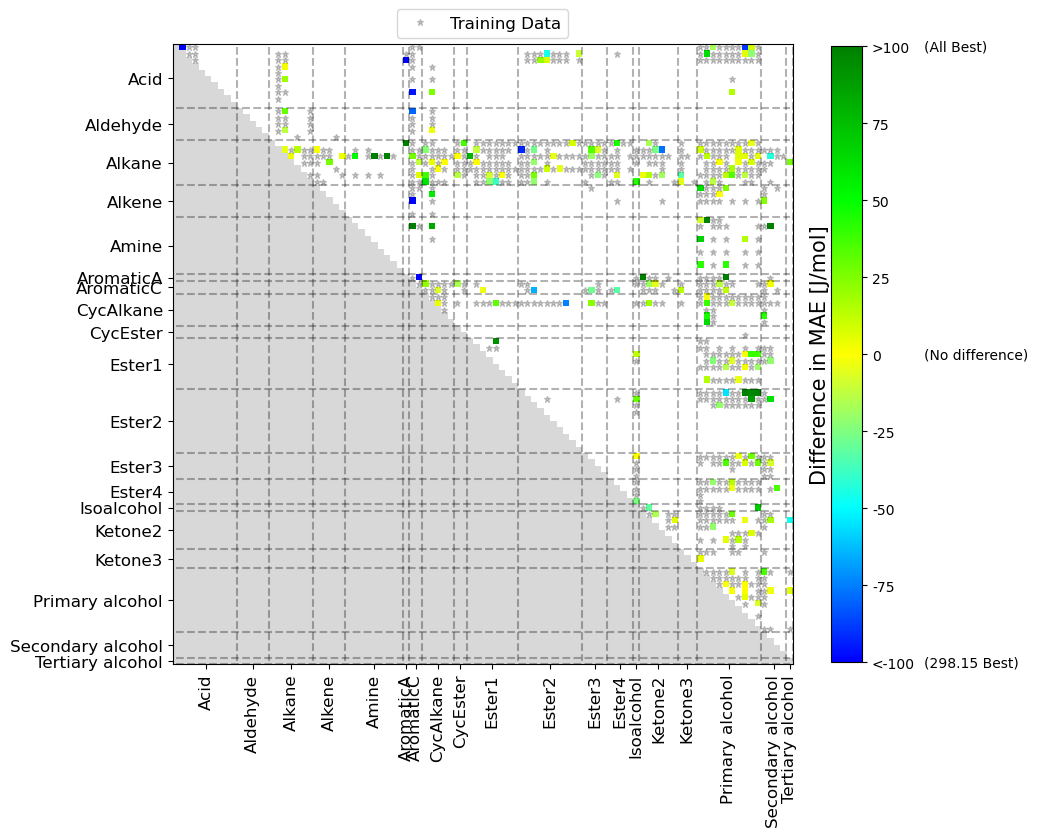

In [7]:
data_type = 'Testing'
cbar_title = 'Difference in MAE [J/mol]'

unique_mix_all, idx = np.unique(np.char.add(np.char.add(data_dict_298_testing['Component 1'], ' + '), data_dict_298_testing['Component 2']), return_index=True)
unique_mix_all = unique_mix_all[np.argsort(idx)]
mix_298 = np.char.add(np.char.add(data_dict_298_testing['Component 1'], ' + '), data_dict_298_testing['Component 2'])
mix_all = np.char.add(np.char.add(data_dict_all_testing['Component 1'], ' + '), data_dict_all_testing['Component 2'])
MAE_298 = []
MAE_all = []

for mix in unique_mix_all:
    idx_mix_298 = mix_298 == mix
    idx_mix_all = mix_all == mix
    idx_T_all = np.abs(data_dict_all_testing['Temperature [K]'][idx_mix_all] - 298.15) <= 0.5

    MAE_298 += [np.mean(np.abs(data_dict_298_testing['MC [J/mol]'][idx_mix_298, ranks_idx] - data_dict_298_testing['Excess Enthalpy [J/mol]'][idx_mix_298]))]
    MAE_all += [np.mean(np.abs(data_dict_all_testing['MC [J/mol]'][idx_mix_all, ranks_idx][idx_T_all] - data_dict_all_testing['Excess Enthalpy [J/mol]'][idx_mix_all][idx_T_all]))]

A_diff = np.nan*np.zeros((len(c_all), len(c_all)))
diff = np.array(MAE_298) - np.array(MAE_all)
A_diff[testing_indices[:,0], testing_indices[:,1]] = diff

N = len(c_all)
max_val = 100

fig,ax = plt.subplots(figsize=(10,10))

cmap = LinearSegmentedColormap.from_list('RdYlGn_r', [(0, 'blue'), (0.25, 'cyan'), (0.5, 'yellow'), (0.75, 'lime'), (1, 'green')], N=256)
im = ax.imshow(A_diff, cmap=cmap, vmin=-max_val, vmax=max_val)
cbar = fig.colorbar(im, shrink=0.8)
c_ticks = cbar.get_ticks().astype(int)
c_tick_labels = c_ticks.astype(str)
c_tick_labels[0] = f'<{c_tick_labels[0]}'
c_tick_labels[-1] = f'>{c_tick_labels[-1]}'
cbar.set_ticks(c_ticks)
cbar.set_ticklabels(c_tick_labels)

A_grey = np.nan*np.eye(N)
for i in range(N):
    for j in range(i,N):
        A_grey[j,i] = 0.25
    
ax.imshow(A_grey, cmap='Greys',vmin=0,vmax=1)

unique_fg, idx, counts = np.unique(fg, return_index=True, return_counts=True)
unique_fg = unique_fg[np.argsort(idx)]
counts = counts[np.argsort(idx)]
counts[0]=counts[0]-1
counts = counts

end_points = [0]
for count in np.cumsum(counts):
    count += 0.5
    end_points += [count]
    ax.plot([count, count], [0, N-1], '--k', alpha=0.3)
    ax.plot([0, N-1], [count, count], '--k', alpha=0.3)

if data_type == 'Testing':
    ax.plot(Idx_known[:,1], Idx_known[:,0], '*k', markersize=5, alpha=0.2, label='Training Data')
    ax.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.5, 1.07))

mid_points = (np.array(end_points[:-1])+np.array(end_points[1:]))/2
ax.set_xticks(mid_points, unique_fg, rotation=90, fontsize=12)
ax.set_yticks(mid_points, unique_fg, fontsize=12)

# Add text to the color bar
# Get the position of the colorbar's axis
cbar_pos = cbar.ax.get_position()  # Returns a Bbox object

# Extract the bounding box coordinates: (x0, y0) is the bottom-left corner, and (width, height) are its dimensions
x0, y0, width, height = cbar_pos.x0, cbar_pos.y0, cbar_pos.width, cbar_pos.height

# Calculate the vertical positions for the text: bottom, middle, and top of the colorbar
text_positions = [y0, y0 + height / 2, y0 + 0.9999*height]

# Add text next to these positions using fig.text
fig.text(x0 + 0.8*width, text_positions[0], '(298.15 Best)', ha='left', va='center')  # Bottom text
fig.text(x0 + 0.8*width, text_positions[1], '(No difference)', ha='left', va='center')  # Middle text
fig.text(x0 + 0.8*width, text_positions[2], '(All Best)', ha='left', va='center')     # Top text
fig.text(x0 - 0.1*width, text_positions[1], cbar_title, ha='center', va='center', rotation=90, fontsize=15)  # Middle text

plt.savefig(f'{png_path}/MAE_diff_{data_type}.png', dpi=500, bbox_inches='tight')

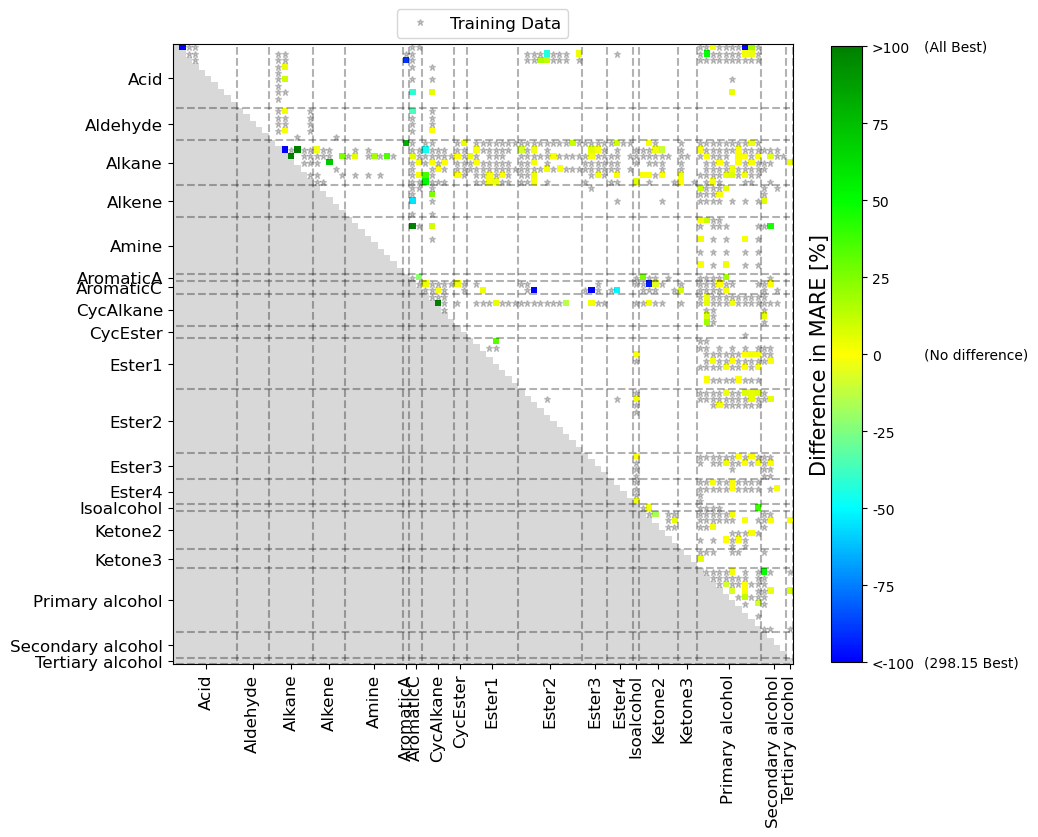

In [8]:
data_type = 'Testing'
cbar_title = 'Difference in MARE [%]'

unique_mix_all, idx = np.unique(np.char.add(np.char.add(data_dict_298_testing['Component 1'], ' + '), data_dict_298_testing['Component 2']), return_index=True)
unique_mix_all = unique_mix_all[np.argsort(idx)]
mix_298 = np.char.add(np.char.add(data_dict_298_testing['Component 1'], ' + '), data_dict_298_testing['Component 2'])
mix_all = np.char.add(np.char.add(data_dict_all_testing['Component 1'], ' + '), data_dict_all_testing['Component 2'])
MAE_298 = []
MAE_all = []

for mix in unique_mix_all:
    idx_mix_298 = mix_298 == mix
    idx_mix_all = mix_all == mix
    idx_T_all = np.abs(data_dict_all_testing['Temperature [K]'][idx_mix_all] - 298.15) <= 0.5

    MAE_298 += [np.mean(np.abs(data_dict_298_testing['MC [J/mol]'][idx_mix_298, ranks_idx] - data_dict_298_testing['Excess Enthalpy [J/mol]'][idx_mix_298])/np.abs(data_dict_298_testing['Excess Enthalpy [J/mol]'][idx_mix_298]))*100]
    MAE_all += [np.mean(np.abs(data_dict_all_testing['MC [J/mol]'][idx_mix_all, ranks_idx][idx_T_all] - data_dict_all_testing['Excess Enthalpy [J/mol]'][idx_mix_all][idx_T_all])/np.abs(data_dict_all_testing['Excess Enthalpy [J/mol]'][idx_mix_all][idx_T_all]))*100]

A_diff = np.nan*np.zeros((len(c_all), len(c_all)))
diff = np.array(MAE_298) - np.array(MAE_all)
A_diff[testing_indices[:,0], testing_indices[:,1]] = diff

N = len(c_all)
max_val = 100

fig,ax = plt.subplots(figsize=(10,10))

cmap = LinearSegmentedColormap.from_list('RdYlGn_r', [(0, 'blue'), (0.25, 'cyan'), (0.5, 'yellow'), (0.75, 'lime'), (1, 'green')], N=256)
im = ax.imshow(A_diff, cmap=cmap, vmin=-max_val, vmax=max_val)
cbar = fig.colorbar(im, shrink=0.8)
c_ticks = cbar.get_ticks().astype(int)
c_tick_labels = c_ticks.astype(str)
c_tick_labels[0] = f'<{c_tick_labels[0]}'
c_tick_labels[-1] = f'>{c_tick_labels[-1]}'
cbar.set_ticks(c_ticks)
cbar.set_ticklabels(c_tick_labels)

A_grey = np.nan*np.eye(N)
for i in range(N):
    for j in range(i,N):
        A_grey[j,i] = 0.25
    
ax.imshow(A_grey, cmap='Greys',vmin=0,vmax=1)

unique_fg, idx, counts = np.unique(fg, return_index=True, return_counts=True)
unique_fg = unique_fg[np.argsort(idx)]
counts = counts[np.argsort(idx)]
counts[0]=counts[0]-1
counts = counts

end_points = [0]
for count in np.cumsum(counts):
    count += 0.5
    end_points += [count]
    ax.plot([count, count], [0, N-1], '--k', alpha=0.3)
    ax.plot([0, N-1], [count, count], '--k', alpha=0.3)

if data_type == 'Testing':
    ax.plot(Idx_known[:,1], Idx_known[:,0], '*k', markersize=5, alpha=0.2, label='Training Data')
    ax.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.5, 1.07))

mid_points = (np.array(end_points[:-1])+np.array(end_points[1:]))/2
ax.set_xticks(mid_points, unique_fg, rotation=90, fontsize=12)
ax.set_yticks(mid_points, unique_fg, fontsize=12)

# Add text to the color bar
# Get the position of the colorbar's axis
cbar_pos = cbar.ax.get_position()  # Returns a Bbox object

# Extract the bounding box coordinates: (x0, y0) is the bottom-left corner, and (width, height) are its dimensions
x0, y0, width, height = cbar_pos.x0, cbar_pos.y0, cbar_pos.width, cbar_pos.height

# Calculate the vertical positions for the text: bottom, middle, and top of the colorbar
text_positions = [y0, y0 + height / 2, y0 + 0.9999*height]

# Add text next to these positions using fig.text
fig.text(x0 + 0.8*width, text_positions[0], '(298.15 Best)', ha='left', va='center')  # Bottom text
fig.text(x0 + 0.8*width, text_positions[1], '(No difference)', ha='left', va='center')  # Middle text
fig.text(x0 + 0.8*width, text_positions[2], '(All Best)', ha='left', va='center')     # Top text
fig.text(x0 - 0.1*width, text_positions[1], cbar_title, ha='center', va='center', rotation=90, fontsize=15)  # Middle text

plt.savefig(f'{png_path}/MARE_diff_{data_type}.png', dpi=500, bbox_inches='tight')

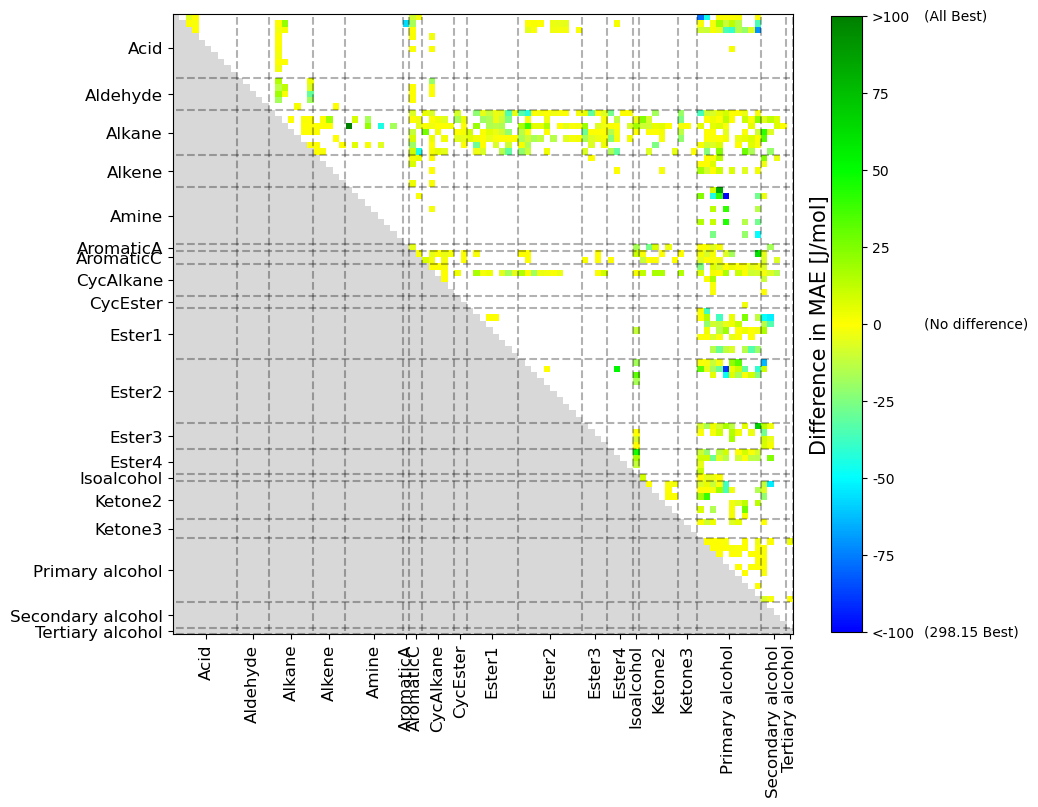

In [9]:
data_type = 'Training'
cbar_title = 'Difference in MAE [J/mol]'

unique_mix_all, idx = np.unique(np.char.add(np.char.add(data_dict_298_training['Component 1'], ' + '), data_dict_298_training['Component 2']), return_index=True)
unique_mix_all = unique_mix_all[np.argsort(idx)]
mix_298 = np.char.add(np.char.add(data_dict_298_training['Component 1'], ' + '), data_dict_298_training['Component 2'])
mix_all = np.char.add(np.char.add(data_dict_all_training['Component 1'], ' + '), data_dict_all_training['Component 2'])
MAE_298 = []
MAE_all = []

for mix in unique_mix_all:
    idx_mix_298 = mix_298 == mix
    idx_mix_all = mix_all == mix
    idx_T_all = np.abs(data_dict_all_training['Temperature [K]'][idx_mix_all] - 298.15) <= 0.5

    MAE_298 += [np.mean(np.abs(data_dict_298_training['MC [J/mol]'][idx_mix_298, ranks_idx] - data_dict_298_training['Excess Enthalpy [J/mol]'][idx_mix_298]))]
    MAE_all += [np.mean(np.abs(data_dict_all_training['MC [J/mol]'][idx_mix_all, ranks_idx][idx_T_all] - data_dict_all_training['Excess Enthalpy [J/mol]'][idx_mix_all][idx_T_all]))]

A_diff = np.nan*np.zeros((len(c_all), len(c_all)))
diff = np.array(MAE_298) - np.array(MAE_all)
A_diff[Idx_known[:,0], Idx_known[:,1]] = diff

N = len(c_all)
max_val = 100

fig,ax = plt.subplots(figsize=(10,10))

cmap = LinearSegmentedColormap.from_list('RdYlGn_r', [(0, 'blue'), (0.25, 'cyan'), (0.5, 'yellow'), (0.75, 'lime'), (1, 'green')], N=256)
im = ax.imshow(A_diff, cmap=cmap, vmin=-max_val, vmax=max_val)
cbar = fig.colorbar(im, shrink=0.8)
c_ticks = cbar.get_ticks().astype(int)
c_tick_labels = c_ticks.astype(str)
c_tick_labels[0] = f'<{c_tick_labels[0]}'
c_tick_labels[-1] = f'>{c_tick_labels[-1]}'
cbar.set_ticks(c_ticks)
cbar.set_ticklabels(c_tick_labels)

A_grey = np.nan*np.eye(N)
for i in range(N):
    for j in range(i,N):
        A_grey[j,i] = 0.25
    
ax.imshow(A_grey, cmap='Greys',vmin=0,vmax=1)

unique_fg, idx, counts = np.unique(fg, return_index=True, return_counts=True)
unique_fg = unique_fg[np.argsort(idx)]
counts = counts[np.argsort(idx)]
counts[0]=counts[0]-1
counts = counts

end_points = [0]
for count in np.cumsum(counts):
    count += 0.5
    end_points += [count]
    ax.plot([count, count], [0, N-1], '--k', alpha=0.3)
    ax.plot([0, N-1], [count, count], '--k', alpha=0.3)

if data_type == 'Testing':
    ax.plot(Idx_known[:,1], Idx_known[:,0], '*k', markersize=5, alpha=0.2, label='Training Data')
    ax.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.5, 1.07))

mid_points = (np.array(end_points[:-1])+np.array(end_points[1:]))/2
ax.set_xticks(mid_points, unique_fg, rotation=90, fontsize=12)
ax.set_yticks(mid_points, unique_fg, fontsize=12)

# Add text to the color bar
# Get the position of the colorbar's axis
cbar_pos = cbar.ax.get_position()  # Returns a Bbox object

# Extract the bounding box coordinates: (x0, y0) is the bottom-left corner, and (width, height) are its dimensions
x0, y0, width, height = cbar_pos.x0, cbar_pos.y0, cbar_pos.width, cbar_pos.height

# Calculate the vertical positions for the text: bottom, middle, and top of the colorbar
text_positions = [y0, y0 + height / 2, y0 + 0.9999*height]

# Add text next to these positions using fig.text
fig.text(x0 + 0.8*width, text_positions[0], '(298.15 Best)', ha='left', va='center')  # Bottom text
fig.text(x0 + 0.8*width, text_positions[1], '(No difference)', ha='left', va='center')  # Middle text
fig.text(x0 + 0.8*width, text_positions[2], '(All Best)', ha='left', va='center')     # Top text
fig.text(x0 - 0.1*width, text_positions[1], cbar_title, ha='center', va='center', rotation=90, fontsize=15)  # Middle text

plt.savefig(f'{png_path}/MAE_diff_{data_type}.png', dpi=500, bbox_inches='tight')

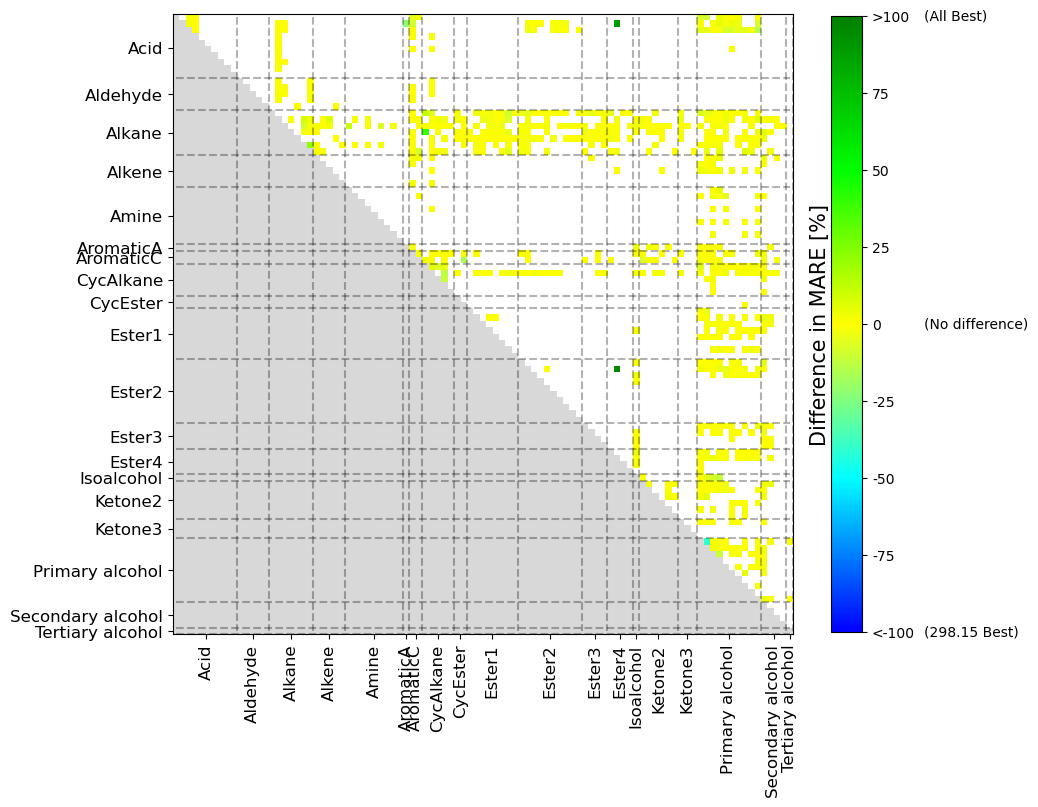

In [10]:
data_type = 'Training'
cbar_title = 'Difference in MARE [%]'

unique_mix_all, idx = np.unique(np.char.add(np.char.add(data_dict_298_training['Component 1'], ' + '), data_dict_298_training['Component 2']), return_index=True)
unique_mix_all = unique_mix_all[np.argsort(idx)]
mix_298 = np.char.add(np.char.add(data_dict_298_training['Component 1'], ' + '), data_dict_298_training['Component 2'])
mix_all = np.char.add(np.char.add(data_dict_all_training['Component 1'], ' + '), data_dict_all_training['Component 2'])
MAE_298 = []
MAE_all = []

for mix in unique_mix_all:
    idx_mix_298 = mix_298 == mix
    idx_mix_all = mix_all == mix
    idx_T_all = np.abs(data_dict_all_training['Temperature [K]'][idx_mix_all] - 298.15) <= 0.5

    MAE_298 += [np.mean(np.abs(data_dict_298_training['MC [J/mol]'][idx_mix_298, ranks_idx] - data_dict_298_training['Excess Enthalpy [J/mol]'][idx_mix_298])/np.abs(data_dict_298_training['Excess Enthalpy [J/mol]'][idx_mix_298]))*100]
    MAE_all += [np.mean(np.abs(data_dict_all_training['MC [J/mol]'][idx_mix_all, ranks_idx][idx_T_all] - data_dict_all_training['Excess Enthalpy [J/mol]'][idx_mix_all][idx_T_all])/np.abs(data_dict_all_training['Excess Enthalpy [J/mol]'][idx_mix_all][idx_T_all]))*100]

A_diff = np.nan*np.zeros((len(c_all), len(c_all)))
diff = np.array(MAE_298) - np.array(MAE_all)
A_diff[Idx_known[:,0], Idx_known[:,1]] = diff

N = len(c_all)
max_val = 100

fig,ax = plt.subplots(figsize=(10,10))

cmap = LinearSegmentedColormap.from_list('RdYlGn_r', [(0, 'blue'), (0.25, 'cyan'), (0.5, 'yellow'), (0.75, 'lime'), (1, 'green')], N=256)
im = ax.imshow(A_diff, cmap=cmap, vmin=-max_val, vmax=max_val)
cbar = fig.colorbar(im, shrink=0.8)
c_ticks = cbar.get_ticks().astype(int)
c_tick_labels = c_ticks.astype(str)
c_tick_labels[0] = f'<{c_tick_labels[0]}'
c_tick_labels[-1] = f'>{c_tick_labels[-1]}'
cbar.set_ticks(c_ticks)
cbar.set_ticklabels(c_tick_labels)

A_grey = np.nan*np.eye(N)
for i in range(N):
    for j in range(i,N):
        A_grey[j,i] = 0.25
    
ax.imshow(A_grey, cmap='Greys',vmin=0,vmax=1)

unique_fg, idx, counts = np.unique(fg, return_index=True, return_counts=True)
unique_fg = unique_fg[np.argsort(idx)]
counts = counts[np.argsort(idx)]
counts[0]=counts[0]-1
counts = counts

end_points = [0]
for count in np.cumsum(counts):
    count += 0.5
    end_points += [count]
    ax.plot([count, count], [0, N-1], '--k', alpha=0.3)
    ax.plot([0, N-1], [count, count], '--k', alpha=0.3)

if data_type == 'Testing':
    ax.plot(Idx_known[:,1], Idx_known[:,0], '*k', markersize=5, alpha=0.2, label='Training Data')
    ax.legend(loc='upper center', fontsize=12, bbox_to_anchor=(0.5, 1.07))

mid_points = (np.array(end_points[:-1])+np.array(end_points[1:]))/2
ax.set_xticks(mid_points, unique_fg, rotation=90, fontsize=12)
ax.set_yticks(mid_points, unique_fg, fontsize=12)

# Add text to the color bar
# Get the position of the colorbar's axis
cbar_pos = cbar.ax.get_position()  # Returns a Bbox object

# Extract the bounding box coordinates: (x0, y0) is the bottom-left corner, and (width, height) are its dimensions
x0, y0, width, height = cbar_pos.x0, cbar_pos.y0, cbar_pos.width, cbar_pos.height

# Calculate the vertical positions for the text: bottom, middle, and top of the colorbar
text_positions = [y0, y0 + height / 2, y0 + 0.9999*height]

# Add text next to these positions using fig.text
fig.text(x0 + 0.8*width, text_positions[0], '(298.15 Best)', ha='left', va='center')  # Bottom text
fig.text(x0 + 0.8*width, text_positions[1], '(No difference)', ha='left', va='center')  # Middle text
fig.text(x0 + 0.8*width, text_positions[2], '(All Best)', ha='left', va='center')     # Top text
fig.text(x0 - 0.1*width, text_positions[1], cbar_title, ha='center', va='center', rotation=90, fontsize=15)  # Middle text

plt.savefig(f'{png_path}/MARE_diff_{data_type}.png', dpi=500, bbox_inches='tight')

In [17]:
v_MC = json.load(open(post_obj.data_file, 'r'))['v_MC']
jitter = json.load(open(post_obj.data_file, 'r'))['jitter']

x2_int = np.array(json.load(open(post_obj.data_file, 'r'))['x2_int'])
T2_int = np.array(json.load(open(post_obj.data_file, 'r'))['T2_int'])

x_MC_298 = x2_int.copy()
T_MC_298 = T2_int[1]*np.ones_like(x_MC_298)

x_MC_all = np.concatenate([x2_int for _ in T2_int])
T_MC_all = np.concatenate([t*np.ones_like(x2_int) for t in T2_int])

In [20]:
x_plot = np.linspace(0, 1, 101)
T_plot = 298.15*np.ones_like(x_plot)

K_MC_298 = post_obj.K(x_MC_298, x_MC_298, T_MC_298, T_MC_298) + (jitter + v_MC)*np.eye(len(x_MC_298))
L_MC_298 = np.linalg.cholesky(K_MC_298)
L_MC_298_inv = np.linalg.inv(L_MC_298)
K_MC_298_inv = L_MC_298_inv.T @ L_MC_298_inv
del K_MC_298, L_MC_298, L_MC_298_inv
map_298 = post_obj.K(x_plot, x_MC_298, T_plot, T_MC_298) @ K_MC_298_inv
del K_MC_298_inv

K_MC_all = post_obj.K(x_MC_all, x_MC_all, T_MC_all, T_MC_all) + (jitter + v_MC)*np.eye(len(x_MC_all))
L_MC_all = np.linalg.cholesky(K_MC_all)
L_MC_all_inv = np.linalg.inv(L_MC_all)
K_MC_all_inv = L_MC_all_inv.T @ L_MC_all_inv
del K_MC_all, L_MC_all, L_MC_all_inv
map_all = post_obj.K(x_plot, x_MC_all, T_plot, T_MC_all) @ K_MC_all_inv
del K_MC_all_inv

In [21]:
plt.close('all')
# Use Agg for saving a lot of plots without opening figure window
matplotlib.use('Agg')

In [28]:
df_UNIFAC = pd.read_excel(post_obj.excel_plots_known)

In [32]:
plot_path = f'{png_path}/Testing'
os.makedirs(plot_path, exist_ok=True)

y_MC_298 = post_obj.extract_interps(A=A_298, Idx=testing_indices)[ranks_idx]
y_MC_all = post_obj.extract_interps(A=A_all, Idx=testing_indices)[ranks_idx]

for n in range(testing_indices.shape[0]):
    i, j = testing_indices[n]
    c1 = post_obj.c_all[i]
    c2 = post_obj.c_all[j]
    c1_idx_298 = data_dict_298_testing['Component 1'] == c1
    c2_idx_298 = data_dict_298_testing['Component 2'] == c2
    c_idx_298 = (c1_idx_298.astype(int) + c2_idx_298.astype(int)) == 2
    c1_UNI = df_UNIFAC['Component 1'].to_numpy().astype(str) == c1
    c2_UNI = df_UNIFAC['Component 2'].to_numpy().astype(str) == c2
    c_UNI = (c1_UNI.astype(int) + c2_UNI.astype(int)) == 2
    T_UNI_idx = np.abs(df_UNIFAC['Temperature [K]'].to_numpy().astype(float)[c_UNI] - 298.15) <= 0.5

    y_MC_plot_298 = map_298 @ y_MC_298[:,n]
    y_MC_plot_all = map_all @ y_MC_all[:,n]


    x_UNI = df_UNIFAC['Composition component 1 [mol/mol]'].to_numpy().astype(float)[c_UNI][T_UNI_idx]
    y_UNI = df_UNIFAC['UNIFAC_DMD [J/mol]'].to_numpy().astype(float)[c_UNI][T_UNI_idx]

    xx = data_dict_298_testing['Composition component 1 [mol/mol]'][c_idx_298]
    yy = data_dict_298_testing['Excess Enthalpy [J/mol]'][c_idx_298]

    fig, ax = plt.subplots()
    ax.plot(x_plot, y_MC_plot_298, '-b', label='MC 298.15 K')
    ax.plot(x_plot, y_MC_plot_all, '-g', label='MC All T')
    ax.plot(x_UNI, y_UNI, '-r', label='UNIFAC')
    ax.plot(xx, yy, '.k', label='Experimental Data', markersize=15)
    ax.set_xlabel('Composition of Compound 1 [mol/mol]', fontsize=15)
    ax.set_ylabel('Excess Enthalpy [J/mol]', fontsize=18)
    ax.set_title(f'(1) {c1} + (2) {c2} at 298.15 K', fontsize=13)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tight_layout()

    fig_path = f'{plot_path}/{n}.png'
    fig.savefig(fig_path, dpi=300)
    plt.clf()
    plt.close()

    clear_output(wait=False)
    print(f'{n}')

188


In [33]:
plot_path = f'{png_path}/Training'
os.makedirs(plot_path, exist_ok=True)

y_MC_298 = post_obj.extract_interps(A=A_298, Idx=Idx_known)[ranks_idx]
y_MC_all = post_obj.extract_interps(A=A_all, Idx=Idx_known)[ranks_idx]

for n in range(Idx_known.shape[0]):
    i, j = Idx_known[n]
    c1 = post_obj.c_all[i]
    c2 = post_obj.c_all[j]
    c1_idx_298 = data_dict_298_training['Component 1'] == c1
    c2_idx_298 = data_dict_298_training['Component 2'] == c2
    c_idx_298 = (c1_idx_298.astype(int) + c2_idx_298.astype(int)) == 2
    c1_UNI = df_UNIFAC['Component 1'].to_numpy().astype(str) == c1
    c2_UNI = df_UNIFAC['Component 2'].to_numpy().astype(str) == c2
    c_UNI = (c1_UNI.astype(int) + c2_UNI.astype(int)) == 2
    T_UNI_idx = np.abs(df_UNIFAC['Temperature [K]'].to_numpy().astype(float)[c_UNI] - 298.15) <= 0.5

    y_MC_plot_298 = map_298 @ y_MC_298[:,n]
    y_MC_plot_all = map_all @ y_MC_all[:,n]


    x_UNI = df_UNIFAC['Composition component 1 [mol/mol]'].to_numpy().astype(float)[c_UNI][T_UNI_idx]
    y_UNI = df_UNIFAC['UNIFAC_DMD [J/mol]'].to_numpy().astype(float)[c_UNI][T_UNI_idx]

    xx = data_dict_298_training['Composition component 1 [mol/mol]'][c_idx_298]
    yy = data_dict_298_training['Excess Enthalpy [J/mol]'][c_idx_298]

    fig, ax = plt.subplots()
    ax.plot(x_plot, y_MC_plot_298, '-b', label='MC 298.15 K')
    ax.plot(x_plot, y_MC_plot_all, '-g', label='MC All T')
    ax.plot(x_UNI, y_UNI, '-r', label='UNIFAC')
    ax.plot(xx, yy, '.k', label='Experimental Data', markersize=15)
    ax.set_xlabel('Composition of Compound 1 [mol/mol]', fontsize=15)
    ax.set_ylabel('Excess Enthalpy [J/mol]', fontsize=18)
    ax.set_title(f'(1) {c1} + (2) {c2} at 298.15 K', fontsize=13)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.tight_layout()

    fig_path = f'{plot_path}/{n}.png'
    fig.savefig(fig_path, dpi=300)
    plt.clf()
    plt.close()

    clear_output(wait=False)
    print(f'{n}')

680
